XGBoost Accuracy: 0.7223382045929019
Classification Report:
              precision    recall  f1-score   support

           A       0.33      0.10      0.15        21
           B       0.54      0.57      0.56        54
           C       0.53      0.65      0.58        78
           D       0.53      0.45      0.48        83
           F       0.90      0.93      0.91       243

    accuracy                           0.72       479
   macro avg       0.57      0.54      0.54       479
weighted avg       0.71      0.72      0.71       479



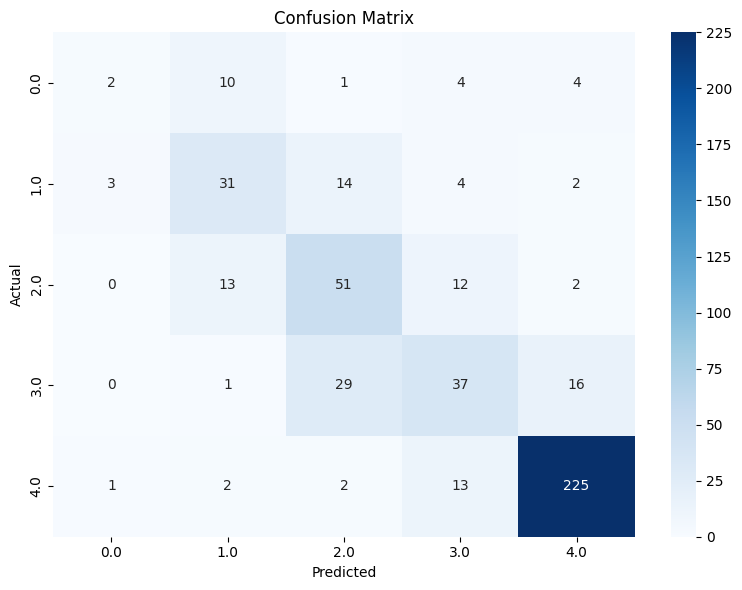

First 20 Predictions:

 First 20 Predictions:
 Actual  Predicted  Match
    4.0          4   True
    4.0          4   True
    4.0          4   True
    4.0          4   True
    2.0          1  False
    3.0          3   True
    2.0          1  False
    4.0          4   True
    4.0          4   True
    3.0          4  False
    2.0          2   True
    4.0          4   True
    4.0          4   True
    3.0          2  False
    4.0          4   True
    4.0          4   True
    0.0          4  False
    4.0          4   True
    3.0          2  False
    4.0          4   True


In [1]:
import pandas as pd
import matplotlib.pyplot as plt  
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

#Step 1: Import CSVs
df_train = pd.read_csv('../data/train_data.csv', delimiter=",")
df_test = pd.read_csv('../data/test_data.csv', delimiter=",")

#Step 2: Separate features and target
X_train = df_train.drop(columns=["StudentID", "GradeClass", "GPA"])
y_train = df_train['GradeClass']

X_test = df_test.drop(columns=["StudentID", "GradeClass", "GPA"])
y_test = df_test['GradeClass']

#Step 3: Build a pipeline of training
from sklearn.pipeline import Pipeline
from category_encoders.target_encoder import TargetEncoder

#Step 4: Train XGBoost Model
pipeline = Pipeline(steps=[
    ('clf', XGBClassifier(eval_metric='mlogloss', random_state=47))
])
#pipe

#Step 5: Set up hyperparameter tuning
from skopt import BayesSearchCV
from skopt.space import Real,Categorical, Integer

search_space = {
    'clf__max_depth' : Integer(2,8),
    'clf__learning_rate' : Real(0.001, 1.0, prior='log-uniform'),
    'clf__subsample' : Real(0.5, 1.0),
    'clf__colsample_bytree' : Real(0.5, 1.0),
    'clf__colsample_bylevel' : Real(0.5, 1.0),
    'clf__colsample_bynode' : Real(0.5, 1.0),
    'clf__reg_alpha' : Real(0.0, 10.0),
    'clf__reg_lambda' : Real(0.0, 10.0),
    'clf__gamma' : Real(0.0, 10.0)
}

#Step 6: Training the XGBoost model
opt = BayesSearchCV(pipeline, search_space, cv=3, n_iter=10, scoring='accuracy', random_state=47)
#Can change cv and n_iter to higher values

opt.fit(X_train, y_train)

#Step 7: Evaluate and make predictions
opt.best_estimator_
opt.best_score_
opt.score(X_test, y_test)
opt.predict(X_test)
opt.predict_proba(X_test)

predictions = opt.predict(X_test)

#Grade mapping
grade_map = {0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'F'}
y_test_letters = pd.Series(y_test).map(grade_map)
y_pred_letters = pd.Series(predictions).map(grade_map)
label_names = [grade_map[i] for i in sorted(grade_map)]

#Step 8: Evaluation
accuracy = accuracy_score(y_test_letters, y_pred_letters)
print("XGBoost Accuracy:", accuracy)
print("Classification Report:")
print(classification_report(y_test_letters, y_pred_letters, target_names=label_names, zero_division=0))

#Confusion Matrix
cm = confusion_matrix(y_test, predictions)
labels = sorted(y_test.unique()) 

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

#Step 9: Save the model as pkl file in artifacts

with open("../artifacts/xgboost_model.pkl", "wb") as file:
   pickle.dump(opt.best_estimator_, file)

#Step 10: Save predictions to CSV
comp_df = X_test.copy()
comp_df["Actual_GradeClass"] = y_test.values
comp_df["Predicted_GradeClass"] = predictions

#Step 11: Show and save the predictions table
try:
    from IPython.display import display

    # Prepare DataFrame for display
    comp_df = pd.DataFrame({"Actual": y_test.values,"Predicted": predictions})
    comp_df["Match"] = comp_df["Actual"] == comp_df["Predicted"]

    def highlight_false_text(row):
        styles = []
        for col in row.index:
            if col == "Match" and row["Match"] == False:
                styles.append("color: red; background-color: black")
            else:
                styles.append("background-color: black; color: white")
        return styles

    print("First 20 Predictions:")
    display(comp_df.head(20).style.apply(highlight_false_text, axis=1))

except Exception as e:
    print("\n First 20 Predictions:")
    print(comp_df.head(20).to_string(index=False))

comp_df.to_csv("../artifacts/xgboost_prediction.csv", index=False)